In [1]:
%%capture
from IPython.display import display, Math, Latex
%pylab inline

In [2]:
%%capture
%run parameter_sampling_planck2015

Now we want to apply a Metropolis-Hastings MCMC to sample parameters for a given power spectrum. 

For a data set $d = As+n$, where n is noise, A is the signal and A is the beam.

Here we produce our own "data set" d: 
- we generate a spectrum $C_\ell$ from a set of parameters (here ~Planck 2015)
- we generate $a_{\ell m}$ using healpy $\texttt{synalm}$
- we apply a 5 arcmin FWMH gaussian beam $b_\ell$ 
- we add a white noise in $a_{\ell m}$ space


This step is only done once. 



Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


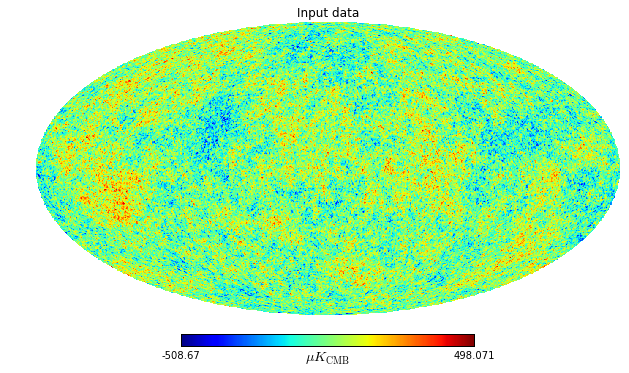

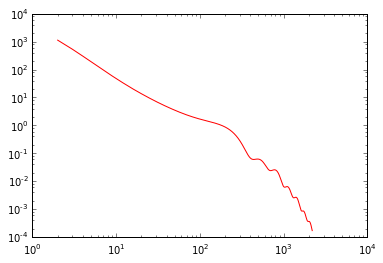

In [3]:
a = plot_input(dlm)

Then we use a Metropolis-Hastings algorithm:
- we generate a random set of parameters $\Omega_0$.
- The target distribution is given by: 
\begin{equation}
\Pi(\Omega \vert d)=\frac{e^{-\frac{1}{2} d (\;A S(\Omega)A^T + N\;) d^T)} }{\sqrt{2\pi \; \vert \; A S(\Omega)A^T + N \; \vert }} \;. 
\end{equation}
Though I am not sure I understand where it comes from.
- The proposal distribution is:
\begin{equation}
w(\Omega_{i+1}\vert \Omega_i)=\frac{e^{-\frac{1}{2} (\Omega_{i+1}- \Omega_{i})^{T} B^{-1}(\Omega_{i+1}- \Omega_{i})}}{\sqrt{2\pi \vert \; B \; \vert }} \;,
\end{equation}
where B is the covariance matrix, calculated using the correlation matrix from figure 42 of the likelihood paper: http://xxx.lanl.gov/pdf/1507.02704v1.pdf. It is shown in next item, along with the triangle plots.
- We then generate a random vector $u$ drawn from the gaussian of covariance $B$, centered on zero, and $\Omega_{i+1} = \Omega_i + u$.
- Since in $\Pi(\Omega_i \vert d)$, we handle some huge numbers, we will work with its logarithm. Then we compute:
\begin{equation}
A = min \left[0,log(\Pi(\Omega_{i+1} \vert d))- log(\Pi(\Omega_{i} \vert d)) +log(w(\Omega_{i}\vert \Omega_{i+1}) -  log(w(\Omega_{i+1}\vert \Omega_i)\right] \;,
\end{equation}
where here actually, the proposal being symmetric, we only need $\Pi$.
- if $A=0$, we accept.
If $A<0$, we generate a random uniform number u: if $log(u)<A$, we accept, other was we refuse the step.



#Problems

-- My issue is that doing so, I reject most of the steps. A is varying so much and get to really big negative values that are never generated by log(u).


-- But my bigger issue is that I don't even understand how $\Pi$ works: let's say I don't vary the parameters, but rather vary directly the spectrum, say by an overall factor. Then shouldn't $\Pi$ be bigger when I am closer to the real spectrum? But here if I multiply by factors growingly bigger than 1, $d_{\ell m}$ being fixed, then $ - d (\;A S(\Omega)A^T + N\;) d^T$ will also grow bigger. So for example it I only vary $A_s$, it diverges towards high values. 

([<matplotlib.text.Text at 0x10a057950>,
 <matplotlib.colorbar.Colorbar instance at 0x109788ea8>)

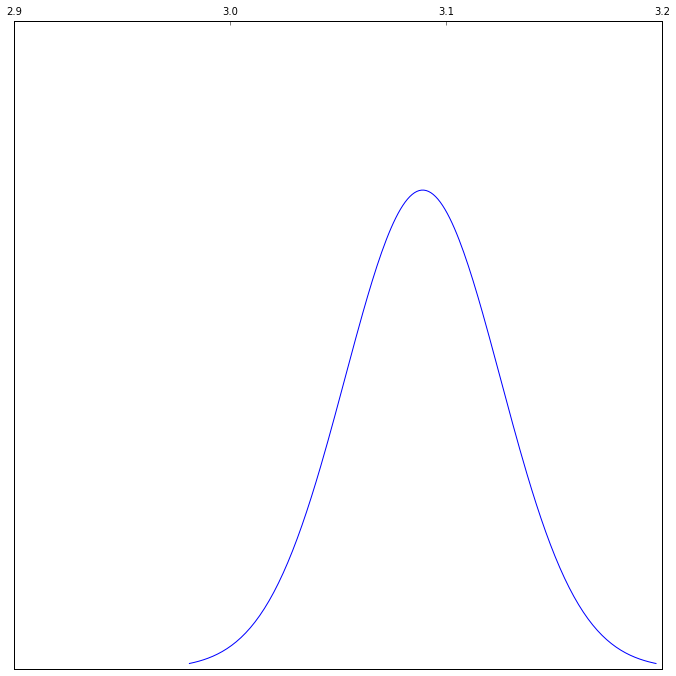

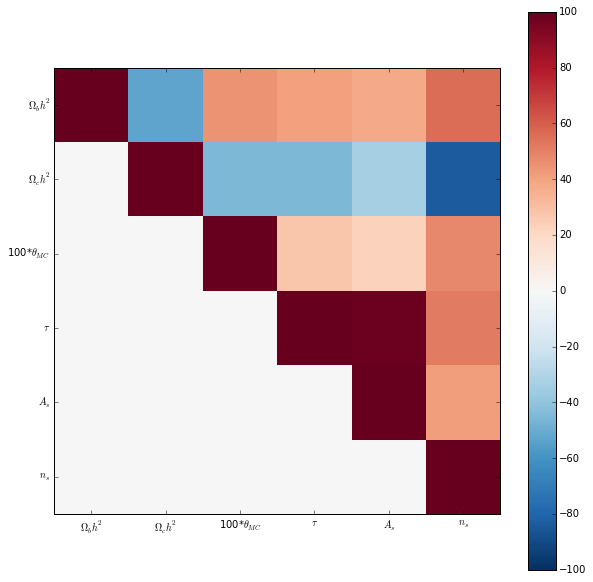

In [4]:
plt.figure(figsize=(10,10));axS,axh = plp.Triangle_plot_Cov(cov_new,x_mean)
plt.figure(figsize=(10,10)),imshow(Correlation_matrix,interpolation="nearest",cmap='RdBu_r',vmin=-100,vmax=100)
ax=plt.gca()
ax.set_xticklabels([""]+titles),ax.set_yticklabels([""]+titles),plt.colorbar()